In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from bbg import bdh, bdh_bulk, Pybbg
import matplotlib.pyplot as plt
import plotly
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import numpy as np
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.express as px
pd.options.plotting.backend = "matplotlib"
import pdblp
from datetime import timedelta

In [2]:
#update etf data
df = pd.read_excel('./data/cny_etf.xlsx' )
# df = df.iloc[1:]
# df['Ticker'] = df['Ticker'].apply(lambda x : x + ' Equity')

# update data
a = Pybbg()
field = a.bdp(ticker = df.Ticker,fld_list =  [ 'DOWNSIDE_RISK','RETURN_SHARPE_RATIO','CURRENT_TRR_3YR','CURRENT_TRR_1YR','EQY_SHARPE_RATIO_1YR','EQY_SHARPE_RATIO_3YR','EQY_SHARPE_RATIO_5YR']).transpose()
field.index.name = 'Ticker'
field.reset_index(inplace = True)
df = df.merge(field, on ='Ticker')
# df.to_excel('./data/cny_etf.xlsx')


In [3]:
# #fill industry
# df['industry'] = np.where(df['Name'].str.contains('omputer')|df['Name'].str.contains('nformation')|df['Name'].str.contains('lectr')|df['Name'].str.contains('rtifi')|df['Name'].str.contains('Tech') |df['Name'].str.contains('Science')|df['Name'].str.contains('Inno') , '科技', df['industry'])
# df['industry'] = np.where(df['Name'].str.contains('emi'), '芯片', df['industry'])
# df['industry'] = np.where(df['Name'].str.contains('New Energy'), '新能源', df['industry'])
# df['industry'] = np.where(df['Name'].str.contains('Defense')|df['Name'].str.contains('军事国防'), 'Technology', df['industry'])
# df['industry'] = np.where(df['Name'].str.contains('ank')|df['Name'].str.contains('金融'), 'Financials', df['industry'])

# df['industry'] = np.where(df['Name'].str.contains('ocial')|df['Name'].str.contains('nvironment')|df['Name'].str.contains('环保'), 'ESG', df['industry'])
# df['industry'] = np.where(df['Name'].str.contains('harma')|df['Name'].str.contains('ealth')|df['Name'].str.contains('edicin'), '医药', df['industry'])
# df['industry'] = np.where(df['Name'].str.contains('onsum')|df['Name'].str.contains('ood')|df['Name'].str.contains('ocho'), '大众消费', df['industry'])
# df['industry'] = np.where(df['Name'].str.contains('etals')|df['Name'].str.contains('aterial'), '材料', df['industry'])
# df['industry'] = np.where(df['Name'].str.contains('dustrials')|df['Name'].str.contains('amuf')|df['Name'].str.contains('gricul'), '工业', df['industry'])

# df['industry'].fillna(value = '综合',inplace = True)
# df['industry'] = df['industry'].replace('Thematics','综合')

In [4]:
#update price data
price = pd.read_csv('./data/cny_price.csv')
price.set_index('date',inplace = True)


startdate =( (pd.to_datetime(price.index[-1])) + timedelta(days = 1)).strftime('%Y%m%d')
con = pdblp.BCon(debug=False, port=8194,timeout=5000)
con.start()
newprice = con.bdh(list(price.columns),'PX_LAST',startdate,'20500101')
newprice
if len(newprice) > 0 :
    print('updating data since ' + startdate)
else: 
    print('No new price data')
    
newprice.columns =  newprice.columns.droplevel(level = 1)
price = price.append(newprice)

price.index  = pd.to_datetime(price.index )
price.to_csv('./data/cny_price.csv')

No new price data


In [5]:
df['style'].fillna(value ='Blend',inplace = True)
df['cap'].fillna(value ='Mix',inplace = True)
df['DOWNSIDE_RISK'] = df['DOWNSIDE_RISK'] * (-1)

In [6]:
# df.to_excel( './data/cny_etf.xlsx')

### Top recommendations

In [7]:
def portfolio_stats(returns, weights, rf): 
    """This function calculates portfolio aggregated returns, volatility and sharpe
    returns:  a dataframe with different asset daily returns
    weight: a matrix allocating weights
    rf : risk free interest rate
    portfolio_stats(data['price_d_rts'][['SPX Index','CCMP Index']].loc['2015-01-01':'2020-01-01'], [0.6,0.4], 0.02)"""
    returns.dropna(inplace  =True)
    #sum(weights * returns)
    #total_returns =( (returns+1 ).cumprod() * weights).sum(axis= 1 )
    mean_returns = ((weights * returns.mean()).sum()) *260
    #portfolio_std = W * covariance matrix of returns * W.transpose()
    weights = np.asmatrix(weights)
    sigma = np.sqrt( weights * np.asmatrix(np.cov(returns.T)) * weights.T)  * np.sqrt(260)
    sharpe = (mean_returns - rf)/float(sigma)
    return mean_returns, float(sigma), sharpe

In [8]:
def get_portfolio_stats( tkr,start_date):
    test = price[[tkr]].loc[start_date:].dropna()
    rts = test/test.shift(1)-1 

    return portfolio_stats(rts,[1],0.04)

In [9]:
stats = {}
stats['itd'] = [get_portfolio_stats( x,'1990-01-01') for x in  df.Ticker]
stats['5y'] = [get_portfolio_stats( x,'2015-01-01') for x in  df.Ticker]
stats['1y'] = [get_portfolio_stats( x,'2020-01-01') for x in  df.Ticker]
stats['ytd'] = [get_portfolio_stats( x,'2021-01-01') for x in  df.Ticker]

In [10]:
for i in stats.keys():
    df[i + '_ann_returns'] = [x[0] for x in stats[i]]
    df[i + '_sharpe'] = [x[2] for x in stats[i]]

In [11]:
# scoring criteri
scoring_dic = {'DOWNSIDE_RISK':0.1,'RETURN_SHARPE_RATIO':0.4,'CURRENT_TRR_1YR':0.1,'EQY_SHARPE_RATIO_1YR':0.1,'itd_sharpe':0.3}


def scoring(scoring_dic): 
    """scoring_dic = {'EQY_SHARPE_RATIO_1YR':0.2,'EQY_SHARPE_RATIO_5YR':0.2,'CURRENT_ANN_TRR_5YR':0.2,'CURRENT_TRR_1YR':0.2,
           'CURRENT_TRR_YTD':0.2} """
    rst = df[['Name','Ticker','style','industry'] + list(scoring_dic.keys())]
    for i in scoring_dic.keys(): 
        rst[i] = (rst[i].rank()) * scoring_dic [i]

    rst['total_score'] = rst[list(scoring_dic.keys())].sum(axis = 1)
    rst['total_score'] = (rst['total_score'] /rst['total_score'].max()) * 100 
    rst = rst.sort_values(by = 'total_score', ascending = False)
    return rst 

recommendation = scoring(scoring_dic)
df = df.merge(recommendation[['Ticker','total_score']]).sort_values(by = 'total_score',ascending = False)
show = df[['Name','Ticker','style','industry','total_score',] + list(scoring_dic.keys())].head(10)
show.columns =['名称', '代码', '风格', '行业', '总评分', '风险指数',
       '总回报夏普指数', '一年收益率', '一年夏普指数',
       '全历史夏普指数']

In [12]:
show

,名称,代码,风格,行业,总评分,风险指数,总回报夏普指数,一年收益率,一年夏普指数,全历史夏普指数
286,SWS MU CSI Innovation 100 ETF,515200 CH Equity,Growth,Technology,100.000000,-17.5071,3.56476,84.85385,2.28,2.389328
258,Penghua CSI Alcohol ETF,512690 CH Equity,Blend,Thematics,97.164247,-23.3392,4.57601,129.21350,2.46,2.285872
303,Fullgoal CSI Consumer 50 ETF,515650 CH Equity,Blend,Health Care,96.846642,-17.8901,3.31951,78.07436,2.09,2.106856
246,Hwabao CSI Medical ETF,512170 CH Equity,Growth,Thematics,95.735027,-20.6494,3.31567,88.45282,2.13,2.251090
226,Hony Horizon CNI Leading Priva,159973 CH Equity,Growth,Thematics,93.829401,-19.7869,2.66161,68.78613,2.02,2.019110
232,Yinhua CSI Research Innovation,159987 CH Equity,Growth,Technology,92.627042,-18.1303,2.56847,61.83275,1.89,1.888418
100,Strategic Emerging Component I,512770 CH Equity,Growth,Thematics,91.560799,-18.9503,3.55655,90.12840,2.15,1.468855
257,Penghua CSI National Defense E,512670 CH Equity,Growth,Technology,90.970962,-21.9951,3.09304,102.67860,2.04,1.728648
90,Founder Fubon SZSE 100 ETF,159961 CH Equity,Growth,Thematics,89.859347,-17.9360,2.42864,58.13215,1.83,1.847867
31,Tianhong ChiNext Board ETF,159977 CH Equity,Growth,Thematics,89.496370,-20.4085,2.49972,65.26915,1.82,1.840774


### 分行业推荐

In [13]:
df.set_index('Ticker', inplace = True )
industrylist = [ x for x in df.industry.unique() if x != np.nan]

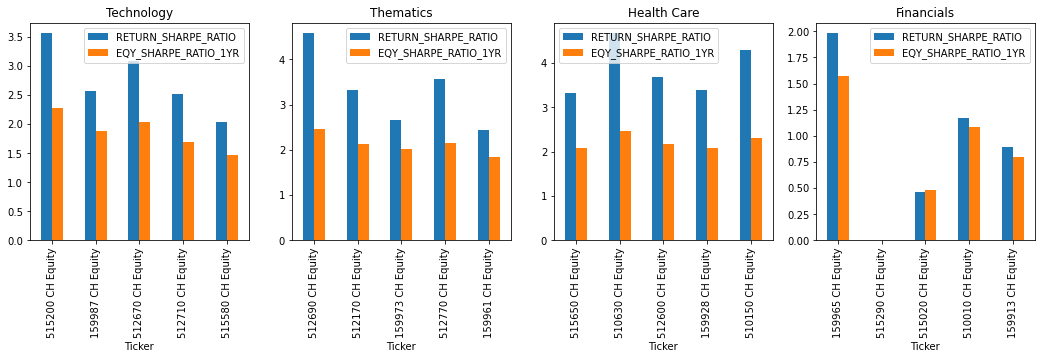

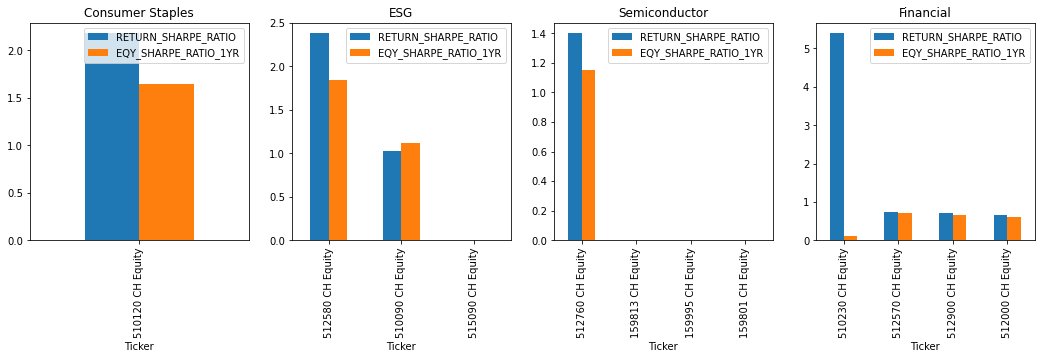

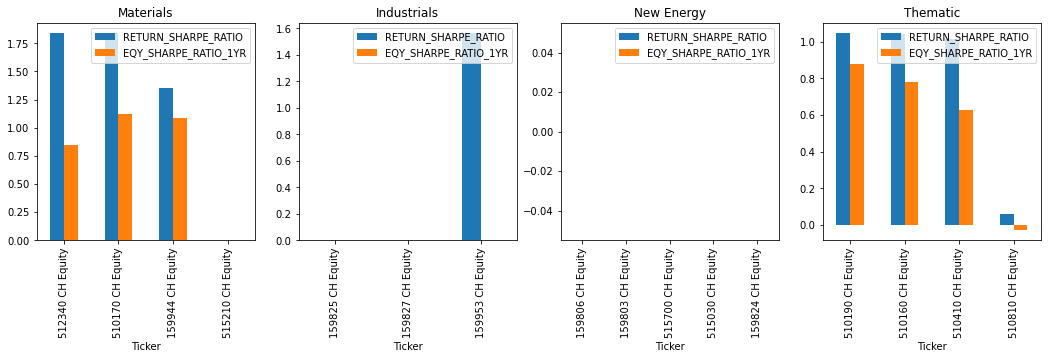

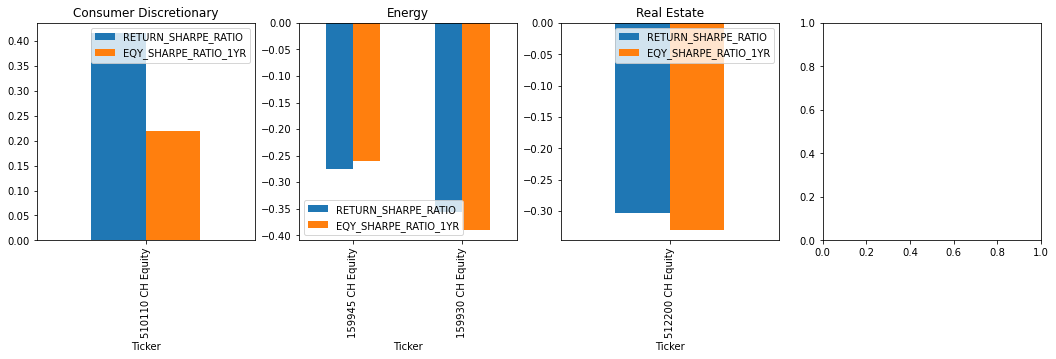

In [14]:

flds = ['RETURN_SHARPE_RATIO','EQY_SHARPE_RATIO_1YR']

for i in range(0, len(industrylist),4):
    try: 
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))  
        df[df.industry == industrylist[i]][['style','industry','total_score'] + list(scoring_dic.keys())].head(5)[flds].plot(kind = 'bar', ax = axes[0], title =str(industrylist[i] ) )
        df[df.industry == industrylist[i+1]][['style','industry','total_score'] + list(scoring_dic.keys())].head(5)[flds].plot(kind = 'bar', ax = axes[1], title = str(industrylist[i+1]) )
        df[df.industry == industrylist[i+2]][['style','industry','total_score'] + list(scoring_dic.keys())].head(5)[flds].plot(kind = 'bar', ax = axes[2], title = str(industrylist[i+2]))
        df[df.industry == industrylist[i+3]][['style','industry','total_score'] + list(scoring_dic.keys())].head(5)[flds].plot(kind = 'bar', ax = axes[3], title = str(industrylist[i+3]) )
    except:
        None

### 根据etf 风格的推荐

<AxesSubplot:title={'center':'Blend'}, xlabel='Ticker'>

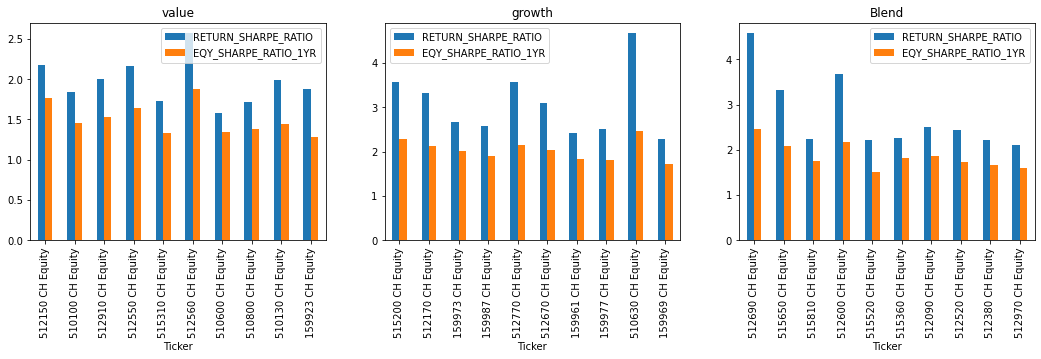

In [15]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))  
df[df['style'] == 'Value'][['style','industry','total_score'] + list(scoring_dic.keys())].head(10)[flds].plot(kind = 'bar', ax = axes[0], title = 'value' )

df[df['style'] == 'Growth'][['style','industry','total_score'] + list(scoring_dic.keys())].head(10)[flds].plot(kind = 'bar', ax = axes[1], title = 'growth' )
df[df['style'] == 'Blend'][['style','industry','total_score'] + list(scoring_dic.keys())].head(10)[flds].plot(kind = 'bar', ax = axes[2], title = 'Blend' )



# 追踪推荐名单

In [16]:
watchlist = pd.DataFrame()
for i in ['Value','Growth','Blend']:
    watchlist = watchlist.append(df[df['style'] == i][['style','industry','total_score'] + list(scoring_dic.keys())].head(10))
    

In [17]:
# price.set_index('date',inplace = True)
# price.index = pd.to_datetime(price.index)

In [18]:
# price = pd.read_csv('./data/cny_price.csv')
# #price = price.iloc[:-5]
# price.set_index('ticker',inplace = True)


# startdate =( (pd.to_datetime(price.index[-1])) + timedelta(days = 1)).strftime('%Y%m%d')
# con = pdblp.BCon(debug=False, port=8194,timeout=5000)
# con.start()
# newprice = con.bdh(list(watchlist.index),'PX_LAST',startdate,'20500101')
# if len(newprice) > 0 :
#     print('updating data since ' + startdate)
# else: 
#     print('No new price data')
    
# newprice.columns =  newprice.columns.droplevel(level = 1)
# price = price.append(newprice)
# price.index.name ='ticker'

# price.index  = pd.to_datetime(price.index )
# price.to_csv('price.csv')

In [19]:
# positioning = con.bdh(list(watchlist.index),['PX_LAST','VOLUME','OPEN_INT_TOTAL_CALL','OPEN_INT_TOTAL_PUT'],'20200901','20500101')
# positioning = (positioning/positioning.shift(26)-1).rolling(26).mean().fillna(method = 'ffill')

In [20]:
# technical = pd.DataFrame(index = [positioning.index[-1]])

# for i in watchlist.index:

#     try: 
#         OPEN_INT = positioning[i]['OPEN_INT_TOTAL_CALL']-positioning[i]['OPEN_INT_TOTAL_PUT']
#         if positioning[i]['PX_LAST'][-1] > 0 and positioning[i]['VOLUME'][-1]  > 0 and OPEN_INT[-1] >  0 : 
#             technical[i] = 3
#         if positioning[i]['PX_LAST'][-1] > 0 and positioning[i]['VOLUME'][-1]  > 0 and OPEN_INT[-1] <  0 : 
#             technical[i] = 2 #call side take profit
#         if positioning[i]['PX_LAST'][-1] > 0 and positioning[i]['VOLUME'][-1]  < 0 and OPEN_INT[-1] <  0 : 
#             technical[i] = 1 #lackluster growth

#         if positioning[i]['PX_LAST'][-1] < 0 and positioning[i]['VOLUME'][-1]  < 0 and OPEN_INT[-1] <  0 : 
#             technical[i] = -1 #lackluster decline

#         if positioning[i]['PX_LAST'][-1] < 0 and positioning[i]['VOLUME'][-1]  > 0 and OPEN_INT[-1] <  0 : 
#             technical[i] = -2 #put side take profit

#         if positioning[i]['PX_LAST'][-1] < 0 and positioning[i]['VOLUME'][-1]  > 0 and OPEN_INT[-1] <  0 : 
#             technical[i] = -3 #lackluster decline

# #         else :
# #             technical[i] = 0
#     except:
#         print(i)
#         technical[i] = 0

In [21]:

# technical.sort_values(by  =technical.index[-1]  ,axis = 1, ascending = False ).iplot(kind ='bar', title = 'Technical signal, 3 as attractive ' )

In [22]:
con = pdblp.BCon(debug=False, port=8194,timeout=5000)
con.start()
newflow = con.bdh(list(watchlist.index),'FUND_FLOW','20200101','20500101')

In [23]:
# price.iplot(title = 'Price from 2005~today')

In [24]:
newflow.rolling(5).mean().iplot(title = '资金流动量图')

In [25]:
newflow.tail(1).sort_values(by  =newflow.index[-1]  ,axis = 1, ascending = False ).iplot(kind ='bar', title = '当日资金流动情况 ' )

In [26]:
newflow.tail(14).iplot( title = '7天资金流动情况 ' )

In [27]:
price = price [watchlist.index]

In [28]:
chg = price/price.shift(5)-1
chg.tail(1).sort_values(by  =chg.index[-1]  ,axis = 1, ascending = False ).iplot(kind ='bar',title = '一周价格变化')

In [29]:
chg = price/price.shift(26*3)-1
chg.tail(1).sort_values(by  =chg.index[-1]  ,axis = 1, ascending = False ).iplot(kind ='bar',title = '三个月价格变化')

In [30]:
chg = price/price.shift(26*12)-1
chg.tail(1).sort_values(by  =chg.index[-1]  ,axis = 1, ascending = False ).iplot(kind ='bar',title = '一年价格变化')

In [31]:
def all_bar_plot(category,metric,top  ):
    rst = pd.DataFrame()
    for i in df[category].unique(): 
        subdf = df[df[category] == i]
        subdf = subdf.sort_values(by = metric, ascending = False).head(top)
        rst = rst.append(subdf)
    rst = rst.sort_values(by =metric, ascending = False)
    rst.reset_index(inplace = True)
    rst.set_index([category,'Ticker'],inplace = True)
    rst[[metric]].iplot(kind='bar',title = metric + ' by ' + category)

In [32]:
all_bar_plot('industry','CURRENT_TRR_1YR',3 )

In [33]:
all_bar_plot('industry','CURRENT_TRR_3YR',3 )

In [34]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')